# Hearing related phenotypes

## Aim

Create a dataset of filtered individuals using the inclusion and exclusion criteria for diverse hearing related phenotyes to perform association analyses using the LMM.ipynb. 

## Location of files

In the shared folder is the original UKBB data
```
/SAY/dbgapstg/scratch/UKBiobank/phenotype_files/pleiotropy_R01/ukb42495_updatedJune2020
```

In my personal folder the filtered dataset

```
/home/dc2325/project/tinnitus
```

## Subset the data using variables of interest

Using the ukbconvert software and a list of pre-specified variables

```
./ukbconv ukb42495.enc_ukb r -i/home/dc2325/project/tinnitus/selectvars_062520.txt -o/home/dc2325/project/tinnitus/ukb42495_subset062520
```

In [1]:
[global]
# The working dir
parameter:cwd = path
# The fam file
parameter: famfile = path

## Subsetting individuals with genotypic data

Load necessary libraries

In [ ]:
library(plyr)
library(tidyverse)
library(pander)
library(ggpubr)

In [2]:
getwd()

[1] "/gpfs/ysm/project/dewan/dc2325/UKBB_GWAS_DEV/analysis"

In [8]:
setwd('~/project/HI_UKBB')

In [4]:
# Clean workspace
rm(list=ls())

In [5]:
# Run script to import data to R
source("ukb42495_subset062520.r")
nrow(bd)

[1] 502505

In [6]:
# List of individuals with qc'ed genotypic files
df.geno <- read.table("/SAY/dbgapstg/scratch/UKBiobank/genotype_files/pleiotropy_geneticfiles/UKB_Caucasians_phenotypeindepqc120319_updated020720removedwithdrawnindiv.fam", header= FALSE, stringsAsFactors = FALSE)
names(df.geno) <-c("FID","IID","ignore1", "ignore2", "ignore3", "ignore4")
nrow(df.geno)

[1] 366745

In [7]:
head(bd[,1, drop=FALSE])

,f.eid
,<int>
1,6025442
2,1000019
3,1000022
4,1000035
5,1000046
6,1000054


In [8]:
# Assign individual ID column to bd f.eid
names(bd)[1] <- "IID"
head(bd[,1, drop=FALSE])

,IID
,<int>
1,6025442
2,1000019
3,1000022
4,1000035
5,1000046
6,1000054


In [9]:
# Merge the two data frames
df.gen.phen <-merge(df.geno, bd, by="IID", all=FALSE)
nrow(df.gen.phen)

[1] 366744

In [10]:
# Step 5 Save as csv file
write.csv(df.gen.phen,'200710_UKBB_HI_genotypeqc.csv', row.names = FALSE)

## 1. Tinnitus phenotype (binary)

### a. Exclusion criteria based on ICD10, ICD9 codes and self-report
Apply the exclusion criteria defined by the group to remove unwanted individuals. This takes into account ICD10 codes, ICD9 codes and f.20002 (self-report). Please find a list of removed codes [here](https://docs.google.com/spreadsheets/d/12L7Cx4Ov8FppGVmG0DxL9uG-lVRHM5QJSea0nORyirQ/edit#gid=0). A total 12397 individuals were excluded in this step.

In [ ]:
# To get a list of removed individuals. Make sure the list with the strings each line has \bstring\b so it can be recognized by -w
cd /home/dc2325/project/HI_UKBB
grep -w -f 200713_ICDcodes_exclusion.txt 200710_UKBB_HI_genotypeqc.csv > 200713_UKBB_excluded_individuals.csv
cat 200713_UKBB_excluded_individuals.csv | wc -l #12397 excluded

In [ ]:
# To get the clean db with the included individuals
grep -wv -f 200713_ICDcodes_exclusion.txt 200710_UKBB_HI_genotypeqc.csv > 200713_UKBB_genotypeqc_tinnitus_excr.csv
cat 200713_UKBB_genotypeqc_clean.csv | wc -l #354347 retained
# To obtain the duplicate lines (if they exist)
#comm -12 <(sort 200713_UKBB_genotypeqc_tinnitus_excr.csv) <(sort 200713_UKBB_excluded_individuals.csv)

In [29]:
# Import clean data
df <- read.csv(file = "200713_UKBB_genotypeqc_tinnitus_excr.csv", header=TRUE)
dim(df)

[1] 354347   1063

### b. Variable recoding

In [30]:
## Variable recoding
# Recode the f.4308 for every instance 
# Yes contains all three categories
# No = No, never
# Do not know = Do not know
# Prefer not to answer = NA
tin <- c("f.4803.0.0", "f.4803.1.0", "f.4803.2.0", "f.4803.3.0")
noise <- c("f.4825.0.0", "f.4825.1.0", "f.4825.2.0", "f.4825.3.0")
music <- c("f.4836.0.0", "f.4836.1.0", "f.4836.2.0", "f.4836.3.0")
tin.rc <- c("f.4803.0.0_rc", "f.4803.1.0_rc", "f.4803.2.0_rc", "f.4803.3.0_rc")
noise.rc <- c("f.4825.0.0_rc", "f.4825.1.0_rc", "f.4825.2.0_rc", "f.4825.3.0_rc")
music.rc <- c("f.4836.0.0_rc", "f.4836.1.0_rc", "f.4836.2.0_rc", "f.4836.3.0_rc")
ordinal.rc <- c("Yes, now most or all of the time" = "Yes", "Yes, now a lot of the time" = "Yes", "Yes, now some of the time" = "Yes", "Yes, but not now, but have in the past" = "Yes","No, never" = "No","Prefer not to answer"= NA,"Do not know" = "Do not know")
sound.rc <- c("No" = "0", "Yes, for less than a year" = "1", "Yes, for around 1-5 years" = "2","Yes, for more than 5 years" = "3","Prefer not to answer" = NA,"Do not know" = NA )
sound.order <- c("0", "1", "2", "3")

Recode tinnitus variable f.4803

In [31]:
df$f.4803.0.0.rc <- revalue(df$f.4803.0.0, ordinal.rc)
df$f.4803.1.0.rc <- revalue(df$f.4803.1.0, ordinal.rc)
df$f.4803.2.0.rc <- revalue(df$f.4803.2.0, ordinal.rc)
df$f.4803.3.0.rc <- revalue(df$f.4803.3.0, ordinal.rc)
table(df$f.4803.0.0.rc)


Do not know          No         Yes 
       1989       80963       32642 

Recode noisy workplace f.4825

In [32]:
df$f.4825.0.0.rc <- revalue(df$f.4825.0.0, sound.rc)
df$f.4825.0.0.rc <- ordered(df$f.4825.0.0.rc, levels = sound.order)
df$f.4825.1.0.rc <- revalue(df$f.4825.1.0, sound.rc)
df$f.4825.1.0.rc <- ordered(df$f.4825.1.0.rc, levels = sound.order)
df$f.4825.2.0.rc <- revalue(df$f.4825.2.0, sound.rc)
df$f.4825.2.0.rc <- ordered(df$f.4825.2.0.rc, levels = sound.order)
df$f.4825.3.0.rc <- revalue(df$f.4825.3.0, sound.rc)
df$f.4825.3.0.rc <- ordered(df$f.4825.3.0.rc, levels = sound.order)
table(df$f.4825.0.0.rc)


    0     1     2     3 
87528  6234  6640 14264 

In [ ]:
Recode loud music frequency exposure f.4836

In [33]:
df$f.4836.0.0.rc <- revalue(df$f.4836.0.0, sound.rc)
df$f.4836.0.0.rc <- ordered(df$f.4836.0.0.rc, levels = sound.order)
df$f.4836.1.0.rc <- revalue(df$f.4836.1.0, sound.rc)
df$f.4836.1.0.rc <- ordered(df$f.4836.1.0.rc, levels = sound.order)
df$f.4836.2.0.rc <- revalue(df$f.4836.2.0, sound.rc)
df$f.4836.2.0.rc <- ordered(df$f.4836.2.0.rc, levels = sound.order)
df$f.4836.3.0.rc <- revalue(df$f.4836.3.0, sound.rc)
df$f.4836.3.0.rc <- ordered(df$f.4836.3.0.rc, levels = sound.order)
table(df$f.4836.0.0.rc)


     0      1      2      3 
100440   3440   5336   4877 

Recode genetic sex f.22001

In [34]:
table(df$f.22001.0.0)


Female   Male 
192414 161933 

In [35]:
df$sex <- revalue(df$f.22001.0.0, c("Male" = '0', 'Female'='1' ))
table(df$sex)


     1      0 
192414 161933 

### c. Filtering of the tinnitus phenotype

Define cases with tinnitus where all yes categories are considered cases

In [36]:
df$cases <- with(df, ifelse(f.4803.0.0.rc == "No" & (f.4803.1.0.rc == "Yes" | f.4803.2.0.rc == "Yes" | f.4803.3.0.rc == "Yes")
                                                      & !(f.4803.0.0.rc == "No" & f.4803.1.0.rc == "Yes" & f.4803.2.0.rc  %in% c("No", "Do not know") & f.4803.3.0.rc %in% c("No", "Do not know",NA)) 
                                                      & !(f.4803.0.0.rc == "No" & f.4803.1.0.rc %in% c("No", "Do not know") & f.4803.2.0.rc == "Yes" & f.4803.3.0.rc %in% c("No", "Do not know"))
                                                      & !(f.4803.0.0.rc == "No" & f.4803.1.0.rc == "Yes" & f.4803.2.0.rc == "Yes" & f.4803.3.0.rc %in% c("No", "Do not know"))
                                                      | (f.4803.0.0.rc %in% c("Yes",NA) & (f.4803.1.0.rc %in% c("Yes",NA) | f.4803.2.0.rc %in% c("Yes",NA) | f.4803.3.0.rc %in% c("Yes",NA))
                                                         & !(f.4803.0.0.rc %in% c("Yes",NA) & (f.4803.1.0.rc %in% c("No", "Do not know") | f.4803.2.0.rc %in% c("No", "Do not know") | f.4803.3.0.rc %in% c("No", "Do not know")))
                                                         & !(f.4803.0.0.rc %in% c(NA) & f.4803.1.0.rc %in% c(NA) & f.4803.2.0.rc %in% c(NA) & f.4803.3.0.rc %in% c(NA))),
                                                      "Yes", NA))

Number of cases

In [37]:
table(df$cases)


  Yes 
42671 

Define controls (no tinnitus)

In [38]:
df$controls <- with(df, ifelse(f.4803.0.0.rc %in% c("No",NA) & f.4803.1.0.rc %in% c("No", NA) & f.4803.2.0.rc %in% c("No",NA) & f.4803.3.0.rc %in% c("No",NA)
                                                         & !(f.4803.0.0.rc %in% c(NA) & f.4803.1.0.rc%in% c(NA)& f.4803.2.0.rc %in% c(NA) & f.4803.3.0.rc %in% c(NA)),"No", NA))

Number of controls

In [39]:
table(df$controls)


   No 
99411 

Create a column with the binary status for tinnitus of the individuals

In [40]:
df$tinnitus <- coalesce(df$cases, df$controls)
table(df$tinnitus)


   No   Yes 
99411 42671 

In [41]:
# Get the number of NAs
length(which(is.na(df$tinnitus)))

[1] 212265

#### Tinnitus phenotye excluding individuals that reply yes, but not now but have it in the past

### d. Obtaining the age for tinnitus cases and controls

Get the "age at onset" of tinnitus using f.21003 Age when attended assessment centre for each of the instances
For cases first time they replied yes to f.4803

In [42]:
# Get the subset of data to extract age
age_all = df %>% 
  filter(!is.na(tinnitus)) %>%
  select(IID,tinnitus, f.4803.0.0.rc, f.4803.1.0.rc, f.4803.2.0.rc, f.4803.3.0.rc, f.21003.0.0, f.21003.1.0, f.21003.2.0, f.21003.3.0)  # data_filed 210003: Age when attended assessment centre
head(age_all)

,IID,tinnitus,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<chr>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000046,No,NA,NA,No,NA,62,NA,73,NA
2,1000063,No,No,NA,NA,NA,43,NA,NA,NA
3,1000078,No,NA,No,No,NA,52,57,60,NA
4,1000105,Yes,Yes,NA,NA,NA,54,NA,NA,NA
5,1000112,No,NA,NA,No,NA,58,NA,68,NA
6,1000141,No,No,NA,NA,NA,49,NA,NA,NA


In [43]:
# Get the subset data of cases
age_cases = age_all %>% 
  filter(tinnitus=="Yes")  %>%
  select(IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
head(age_cases,12)

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000105,Yes,NA,NA,NA,54,NA,NA,NA
2,1000357,Yes,NA,NA,NA,69,NA,NA,NA
3,1000443,NA,NA,Yes,NA,45,NA,52,NA
4,1000494,Yes,NA,NA,NA,61,NA,NA,NA
5,1000625,Yes,NA,NA,NA,60,NA,NA,NA
6,1000713,Yes,NA,Yes,NA,58,NA,67,NA
7,1000728,Yes,NA,NA,NA,61,NA,NA,NA
8,1000745,Yes,NA,NA,NA,60,NA,NA,NA
9,1000875,Yes,NA,NA,NA,59,NA,NA,NA


In [44]:
# Get the # of column where first replied Yes:
age_cases$visit_idx = apply(age_cases, 1, function(x) unlist(which(x == 'Yes')))
head(age_cases)

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>
1,1000105,Yes,NA,NA,NA,54,NA,NA,NA,2
2,1000357,Yes,NA,NA,NA,69,NA,NA,NA,2
3,1000443,NA,NA,Yes,NA,45,NA,52,NA,4
4,1000494,Yes,NA,NA,NA,61,NA,NA,NA,2
5,1000625,Yes,NA,NA,NA,60,NA,NA,NA,2
6,1000713,Yes,NA,Yes,NA,58,NA,67,NA,"2, 4"


In [45]:
# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.4803.0.0.rc)
offset = which(colnames(age_cases) == 'f.21003.0.0') - which(colnames(age_cases) == 'f.4803.0.0.rc')

# Define the function to extract the first time they said yes for cases 
f=get_age_func <- function(x) {
  visit_index=x[which(colnames(age_cases)=="visit_idx")]
  index=min(unlist(visit_index))+offset
  age=x[index]
  final_age=unlist(age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final age for cases
age_cases$age_final = apply(age_cases, 1, f)

# Show first 6 rows
head(age_cases)
summary(age_cases$age_final)

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000105,Yes,NA,NA,NA,54,NA,NA,NA,2,54
2,1000357,Yes,NA,NA,NA,69,NA,NA,NA,2,69
3,1000443,NA,NA,Yes,NA,45,NA,52,NA,4,52
4,1000494,Yes,NA,NA,NA,61,NA,NA,NA,2,61
5,1000625,Yes,NA,NA,NA,60,NA,NA,NA,2,60
6,1000713,Yes,NA,Yes,NA,58,NA,67,NA,"2, 4",58


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   54.00   61.00   59.55   66.00   81.00 

Get the age for controls last time they replied no to f.4803

In [47]:
# Get the subset data of controls
age_control = age_all %>% 
  filter(tinnitus=="No")  %>%
  select(IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0)
head(age_control,12)

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>
1,1000046,NA,NA,No,NA,62,NA,73,NA
2,1000063,No,NA,NA,NA,43,NA,NA,NA
3,1000078,NA,No,No,NA,52,57,60,NA
4,1000112,NA,NA,No,NA,58,NA,68,NA
5,1000141,No,NA,NA,NA,49,NA,NA,NA
6,1000236,No,NA,No,NA,61,NA,70,NA
7,1000248,No,NA,NA,NA,63,NA,NA,NA
8,1000269,NA,NA,No,NA,60,NA,71,NA
9,1000340,No,NA,NA,NA,54,NA,NA,NA


In [48]:
# Get the # of column where last replied No:
age_control$visit_idx = apply(age_control, 1, function(x) unlist(which(x == 'No')))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0) and the first recode column (i.e.f.4803.0.0.rc)
offset = which(colnames(age_control) == 'f.21003.0.0') - which(colnames(age_control) == 'f.4803.0.0.rc')

# Define the function to extract the last time they said no for control

f=get_age_func <- function(x) {
  visit_index=x[which(colnames(age_control)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  age=x[index]
  age=unlist(age)
  return(age)
}

# Get the final age for controls
age_control$age_final = apply(age_control, 1, f)

# Show first 6 rows
head(age_control)
summary(age_control$age_final)

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000046,NA,NA,No,NA,62,NA,73,NA,4,73
2,1000063,No,NA,NA,NA,43,NA,NA,NA,2,43
3,1000078,NA,No,No,NA,52,57,60,NA,"3, 4",60
4,1000112,NA,NA,No,NA,58,NA,68,NA,4,68
5,1000141,No,NA,NA,NA,49,NA,NA,NA,2,49
6,1000236,No,NA,No,NA,61,NA,70,NA,"2, 4",70


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  40.00   53.00   60.00   59.09   65.00   82.00 

In [49]:
# Merge age_cases and age_controls
age_tinnitus <- rbind(age_cases, age_control) 
dim(age_tinnitus)
head(age_tinnitus)

[1] 142082     11

,IID,f.4803.0.0.rc,f.4803.1.0.rc,f.4803.2.0.rc,f.4803.3.0.rc,f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0,visit_idx,age_final
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<list>,<int>
1,1000105,Yes,NA,NA,NA,54,NA,NA,NA,2,54
2,1000357,Yes,NA,NA,NA,69,NA,NA,NA,2,69
3,1000443,NA,NA,Yes,NA,45,NA,52,NA,4,52
4,1000494,Yes,NA,NA,NA,61,NA,NA,NA,2,61
5,1000625,Yes,NA,NA,NA,60,NA,NA,NA,2,60
6,1000713,Yes,NA,Yes,NA,58,NA,67,NA,"2, 4",58


In [50]:
#Merge with complete database keep the all the rows from original db
df.age = merge(x = df,y = age_tinnitus[,c("IID","age_final")],by="IID", all.x=TRUE)
dim(df.age)

[1] 354347   1079

### e. Checking consistency of the f.4825 noisy workplace and filtering

In [51]:
# Extract subset of data only with the recode columns of noisy workplace variable
data_noise <- df.age %>%
  select(IID, f.4825.0.0.rc,f.4825.1.0.rc,f.4825.2.0.rc,f.4825.3.0.rc) 
dim(data_noise)

[1] 354347      5

In [52]:
# Function to extract all the available answers for 4 visits
# and put them in one list
f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
data_noise$visit<-apply(data_noise, 1, f)
data_noise<-data_noise %>%
  filter(!is.na(visit)) 
head(data_noise)
dim(data_noise)

,IID,f.4825.0.0.rc,f.4825.1.0.rc,f.4825.2.0.rc,f.4825.3.0.rc,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 145367      6

In [53]:
# Function to get the final code for noise_wp
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_noise$noise_wp<-apply(data_noise, 1, f)
data_noise<-data_noise %>%
  filter(!is.na(noise_wp)) 
head(data_noise, 12) # note: noise_wp code generated here is numeric, not factor

,IID,f.4825.0.0.rc,f.4825.1.0.rc,f.4825.2.0.rc,f.4825.3.0.rc,visit,noise_wp
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,3,NA,NA,NA,3,3
9,1000269,NA,NA,0,NA,0,0


In [54]:
# Append the noise variable to the data
df.noise = merge(x = df.age,y = data_noise[,c("IID", "noise_wp")],by="IID", all.x=TRUE)
dim(df.noise)

[1] 354347   1080

### f. Checking consistency of the f.4836 loud music exposure frequency and filtering

In [55]:
# Extract subset of data only with the recode columns of loud music exposure variable f.4836
data_music <-  df.age %>%
  select(IID,f.4836.0.0.rc,f.4836.1.0.rc,f.4836.2.0.rc,f.4836.3.0.rc) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0.rc,f.4836.1.0.rc,f.4836.2.0.rc,f.4836.3.0.rc
,<int>,<ord>,<ord>,<ord>,<ord>
1,1000019,NA,NA,NA,NA
2,1000022,NA,NA,NA,NA
3,1000035,NA,NA,NA,NA
4,1000046,NA,NA,0,NA
5,1000054,NA,NA,NA,NA
6,1000063,0,NA,NA,NA


[1] 354347      5

In [56]:
# Function to extract all the available answers for 4 visits
# and put them in one list

f<-function(x){
  visit<-c()
  for (i in 2:5){
    if (!is.na(x[i]))
    {visit<-c(visit,x[i])}
  }
  if(is.null(visit)){visit=NA}
  else{visit=as.numeric(visit)}
  return (visit)
}

# Apply the above function and remove NAs
                              
data_music$visit<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(visit)) 
head(data_music)
dim(data_music)

,IID,f.4836.0.0.rc,f.4836.1.0.rc,f.4836.2.0.rc,f.4836.3.0.rc,visit
,<int>,<ord>,<ord>,<ord>,<ord>,<list>
1,1000046,NA,NA,0,NA,0
2,1000063,0,NA,NA,NA,0
3,1000078,NA,0,0,NA,"0, 0"
4,1000105,0,NA,NA,NA,0
5,1000112,NA,NA,0,NA,0
6,1000141,0,NA,NA,NA,0


[1] 144706      6

In [58]:
# Function to get the final code for "loud_music"
f<-function(x){
  l=length(x$visit)
  if (l==1){ # only one answer available
    result=x$visit
  }
  else{ # more then one answer available
    result=x$visit[1]
    for (i in 2:l){
      if (x$visit[i] >= x$visit[i-1]){result=x$visit[i]} # consistent ones
      else {result=NA; break} # inconsistent ones
    }
  }
  return(result)
}

# Apply the above function and remove NAs
data_music$loud_music<-apply(data_music, 1, f)
data_music<-data_music %>%
  filter(!is.na(loud_music)) 
head(data_music, 12) # note: loud_music code generated here is numeric, not factor
dim(data_music)

,IID,f.4836.0.0.rc,f.4836.1.0.rc,f.4836.2.0.rc,f.4836.3.0.rc,visit,loud_music
,<int>,<ord>,<ord>,<ord>,<ord>,<list>,<dbl>
1,1000046,NA,NA,0,NA,0,0
2,1000063,0,NA,NA,NA,0,0
3,1000078,NA,0,0,NA,"0, 0",0
4,1000105,0,NA,NA,NA,0,0
5,1000112,NA,NA,0,NA,0,0
6,1000141,0,NA,NA,NA,0,0
7,1000236,0,NA,0,NA,"0, 0",0
8,1000248,0,NA,NA,NA,0,0
9,1000269,NA,NA,0,NA,0,0


[1] 143309      7

In [59]:
# Merge all of the variables in the final dataset
df.final = merge(x = df.noise,y = data_music[,c("IID", "loud_music")],by="IID", all.x=TRUE)
dim(df.final)                            

[1] 354347   1081

In [60]:
head(df.final$age_final)

[1] NA NA NA 73 NA 43

### g. Exporting the final phenotype file Tinnitus with complete cases for association analyses

In [61]:
# Last renaming and recoding
df.final$tinnitus <- revalue(df.final$tinnitus, c("No" = '0', 'Yes'='1' ))
names(df.final)[names(df.final) == "age_final"] <- "age"

# Creating the file for subsequent association analyses

tinnitus_cc <- df.final %>%
  filter(!is.na(tinnitus)) %>%
  select(FID, IID, age, sex, tinnitus, noise_wp, loud_music)
head(tinnitus_cc)
dim(tinnitus_cc)

,FID,IID,age,sex,tinnitus,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0
2,1000063,1000063,43,0,0,0,0
3,1000078,1000078,60,1,0,0,0
4,1000105,1000105,54,1,1,0,0
5,1000112,1000112,68,0,0,0,0
6,1000141,1000141,49,1,0,0,0


[1] 142082      7

In [62]:
length(which(is.na(tinnitus_cc$noise_wp)))

[1] 2164

In [63]:
length(which(is.na(tinnitus_cc$loud_music)))

[1] 2773

In [64]:
length(which(is.na(tinnitus_cc$loud_music) & is.na(tinnitus_cc$noise_wp)))

[1] 301

In [65]:
length(which(is.na(tinnitus_cc$loud_music) | is.na(tinnitus_cc$noise_wp))) #noise variables missing cases

[1] 4636

In [42]:
# Export to file in correct format 
# Contains all tinnitus cases, noise variables some are NA
write.table(tinnitus_cc, '200716_UKBB_Tinnitus_f4803', quote = FALSE, row.names = FALSE)

In [66]:
tinnitus_complete <- df.final %>%
  filter(!is.na(tinnitus) & !is.na(noise_wp) & !is.na(loud_music)) %>%
  select(FID, IID, age, sex, tinnitus, noise_wp, loud_music)
head(tinnitus_complete)
dim(tinnitus_complete)

,FID,IID,age,sex,tinnitus,noise_wp,loud_music
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0
2,1000063,1000063,43,0,0,0,0
3,1000078,1000078,60,1,0,0,0
4,1000105,1000105,54,1,1,0,0
5,1000112,1000112,68,0,0,0,0
6,1000141,1000141,49,1,0,0,0


[1] 137446      7

In [44]:
# Export file tinnitus complete cases (no missing data for noise variables)
write.table(tinnitus_complete,'200722_UKBB_Tinnitus_f4803_completecases', quote = FALSE, row.names = FALSE)

In [45]:
# Export complete database to extract the rest of phenotypes
write.csv(df.final,'200716_UKBB_HI_genotypeqc.csv', row.names = FALSE)

In [20]:
# Import tinnitus complete
tinnitus_complete <- read.table('200722_UKBB_Tinnitus_f4803_completecases',  header=TRUE)
head(tinnitus_complete)

,FID,IID,age,sex,tinnitus,noise_wp,loud_music
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1000046,1000046,73,1,0,0,0
2,1000063,1000063,43,0,0,0,0
3,1000078,1000078,60,1,0,0,0
4,1000105,1000105,54,1,1,0,0
5,1000112,1000112,68,0,0,0,0
6,1000141,1000141,49,1,0,0,0


### h. Imputation of noise variables using average

Calculate mean and median for the entire sample (n=142,082)

In [46]:
mean(tinnitus_cc$noise_wp, na.rm=TRUE)
median(tinnitus_cc$noise_wp, na.rm=TRUE)

[1] 0.5215698

[1] 0

Calculate the mean and median in cases and controls

In [47]:
mean(subset(tinnitus_cc, tinnitus == 1)$noise_wp, na.rm=TRUE)
median(subset(tinnitus_cc, tinnitus == 1)$noise_wp, na.rm=TRUE)

[1] 0.7727718

[1] 0

In [48]:
mean(subset(tinnitus_cc, tinnitus == 0)$noise_wp, na.rm=TRUE)
median(subset(tinnitus_cc, tinnitus == 0)$noise_wp, na.rm=TRUE)

[1] 0.4144912

[1] 0

Impute values of noisy workplace using the median

In [49]:
noise.imp <-df.final %>% 
  filter(!is.na(tinnitus)) %>%
  select(IID, tinnitus, noise_wp) %>%
  group_by(tinnitus) %>%
  mutate(noise_wp=ifelse(is.na(noise_wp),median(noise_wp,na.rm=TRUE),noise_wp))
noise.imp.fin <- rename(noise.imp, noise_imp = noise_wp)
head(noise.imp.fin, 10)

IID,tinnitus,noise_imp
<int>,<chr>,<dbl>
1000046,0,0
1000063,0,0
1000078,0,0
1000105,1,0
1000112,0,0
1000141,0,0
1000236,0,0
1000248,0,3
1000269,0,0


Impute values for loud music exposure using then median

In [50]:
music.imp <-df.final %>% 
  filter(!is.na(tinnitus)) %>%
  select(IID, tinnitus, loud_music) %>%
  group_by(tinnitus) %>%
  mutate(loud_music=ifelse(is.na(loud_music),median(loud_music,na.rm=TRUE),loud_music))
music.imp.fin <- rename(music.imp, music_imp = loud_music )
head(music.imp.fin,10)

IID,tinnitus,music_imp
<int>,<chr>,<dbl>
1000046,0,0
1000063,0,0
1000078,0,0
1000105,1,0
1000112,0,0
1000141,0,0
1000236,0,0
1000248,0,0
1000269,0,0


Merge with complete database

In [51]:
df.noise.imp <- merge(x = df.final,y = noise.imp.fin[,c("IID","noise_imp")],by="IID", all.x=TRUE)

In [52]:
df.final.imp <- merge(x = df.noise.imp,y = music.imp.fin[,c("IID", "music_imp")],by="IID", all.x=TRUE)
dim(df.final.imp)

[1] 354347   1083

In [54]:
tinnitus.imp <- df.final.imp %>%
  filter(!is.na(tinnitus)) %>%
  select(FID, IID, age, sex, tinnitus, noise_imp, music_imp)
head(tinnitus.imp)
dim(tinnitus.imp)

,FID,IID,age,sex,tinnitus,noise_imp,music_imp
,<int>,<int>,<int>,<fct>,<chr>,<dbl>,<dbl>
1,1000046,1000046,73,1,0,0,0
2,1000063,1000063,43,0,0,0,0
3,1000078,1000078,60,1,0,0,0
4,1000105,1000105,54,1,1,0,0
5,1000112,1000112,68,0,0,0,0
6,1000141,1000141,49,1,0,0,0


[1] 142082      7

In [55]:
write.table(tinnitus.imp, '200720_UKBB_Tinnitus_f4803_noise_imp', quote = FALSE, row.names = FALSE)
length(which(is.na(tinnitus.imp$noise_imp)))
length(which(is.na(tinnitus.imp$music_imp)))

[1] 0

[1] 0

In [57]:
write.csv(df.final.imp, '200720_UKBB_HI_genotypeqc_noise_imp.csv', row.names = FALSE)

### i. Descriptive statistics

Are there differences in the sex proportions of tinnitus cases?

In [67]:
female.total = length(which(tinnitus_complete$sex=="1"))
male.total = length(which(tinnitus_complete$sex=="0"))
people.total= c(male.total, female.total)
people.total # Number of male and female in the sample

[1] 63193 74253

In [68]:
female.cases = length(which(tinnitus_complete$tinnitus == "1" & tinnitus_complete$sex == "1"))
male.cases =length(which(tinnitus_complete$tinnitus == "1" & tinnitus_complete$sex == "0")) 
people.cases = c(male.cases, female.cases)
people.cases # Number of male and female cases
prop.test(people.cases, people.total) # Proportion of male and female cases in the total sample are different

[1] 20968 19797


	2-sample test for equality of proportions with continuity correction

data:  people.cases out of people.total
X-squared = 695.18, df = 1, p-value < 2.2e-16
alternative hypothesis: two.sided
95 percent confidence interval:
 0.06032145 0.07006537
sample estimates:
   prop 1    prop 2 
0.3318089 0.2666155 


In [69]:
female.controls = length(which(tinnitus_complete$tinnitus == "0" & tinnitus_complete$sex == "1"))
male.controls = length(which(tinnitus_complete$tinnitus == "0" & tinnitus_complete$sex == "0"))
people.controls = c(male.controls, female.controls)
people.controls # Number of male and female controls
prop.test(people.controls, people.total) # Proportion of male and female controls differ

[1] 42225 54456


	2-sample test for equality of proportions with continuity correction

data:  people.controls out of people.total
X-squared = 695.18, df = 1, p-value < 2.2e-16
alternative hypothesis: two.sided
95 percent confidence interval:
 -0.07006537 -0.06032145
sample estimates:
   prop 1    prop 2 
0.6681911 0.7333845 


Are there differences in the sex proportions and noise variables?

In [70]:
sex.noise=table(tinnitus_complete$noise_wp, tinnitus_complete$sex)
sex.noise
chisq.test(sex.noise) # Noise at workplace is not independent of sex

   
        1     0
  0 66579 40045
  1  1724  5221
  2  2414  5083
  3  3536 12844


	Pearson's Chi-squared test

data:  sex.noise
X-squared = 13803, df = 3, p-value < 2.2e-16


In [71]:
sex.music = table(tinnitus_complete$loud_music, tinnitus_complete$sex)
sex.music
chisq.test(sex.music) # Loud music frequency exposure is not independent of sex

   
        1     0
  0 68708 53215
  1  1410  2399
  2  2431  3582
  3  1704  3997


	Pearson's Chi-squared test

data:  sex.music
X-squared = 2494.3, df = 3, p-value < 2.2e-16


Barplot sex vs noisy workplace

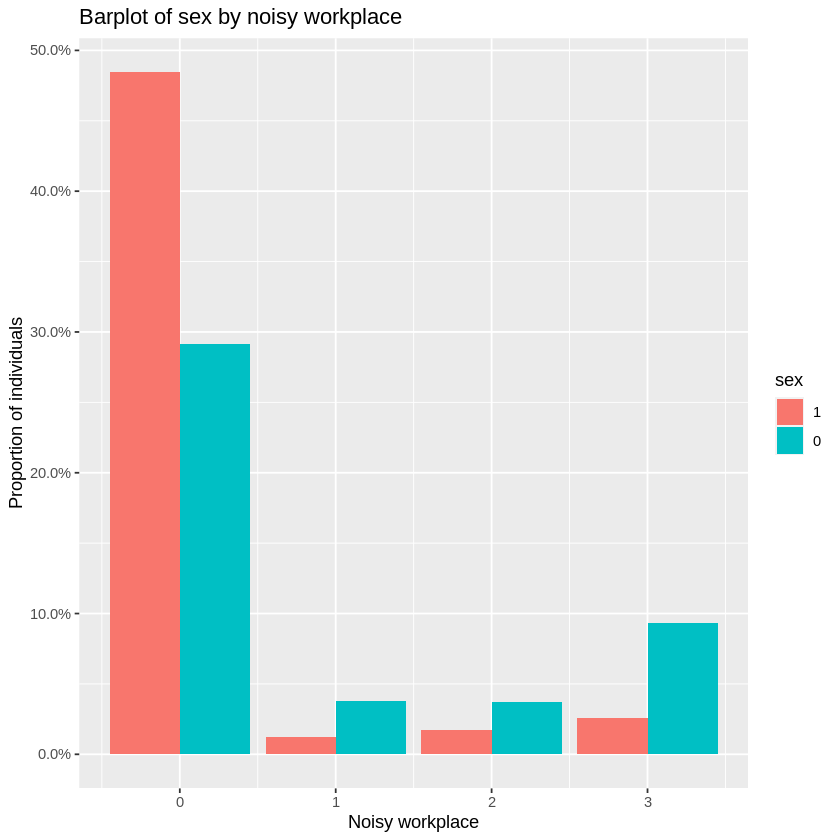

In [72]:
noise.plot <- ggplot(tinnitus_complete, aes(noise_wp)) +
  geom_bar(aes(y=..count../sum(..count..), fill = sex), position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
  labs(title = "Barplot of sex by noisy workplace",
       x = "Noisy workplace", 
       y = "Proportion of individuals")
noise.plot 

Barplot sex vs loud music exposure

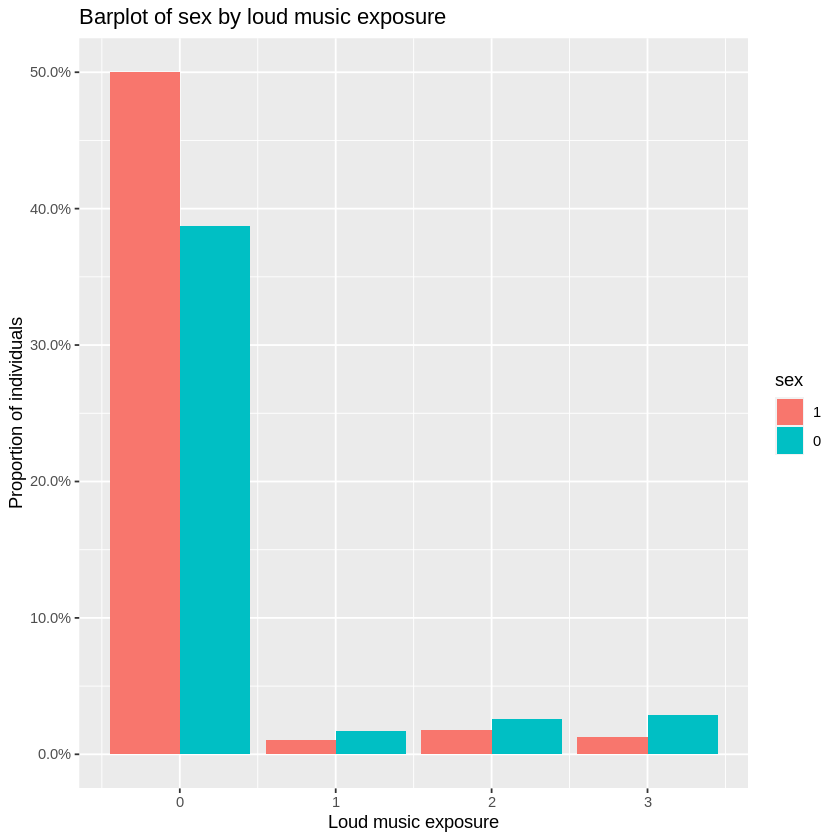

In [73]:
music.plot <- ggplot(tinnitus_complete, aes(loud_music)) +
  geom_bar(aes(y=..count../sum(..count..), fill = sex), position = "dodge") +
  scale_y_continuous(labels = scales::percent) +
labs(title = "Barplot of sex by loud music exposure",
       x = "Loud music exposure", 
       y = "Proportion of individuals")
music.plot

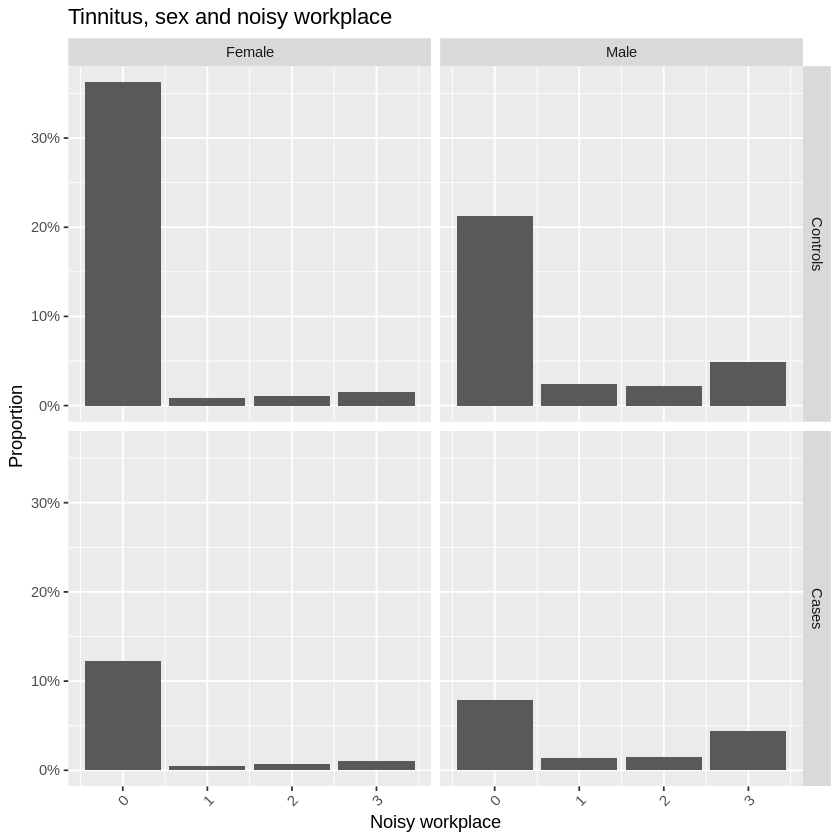

In [76]:
label_sex <- c("1" = "Female", "0" = "Male")
label_tin <- c("1" = "Cases", "0" = "Controls")
sex.tin.noise <- ggplot(tinnitus_complete, aes(x = noise_wp)) +
  geom_bar(aes(y = (..count..)/sum(..count..))) +
  labs(title = "Tinnitus, sex and noisy workplace",
       x = "Noisy workplace", 
       y = "Proportion of individuals") +
  scale_y_continuous(labels = scales::percent, name = "Proportion") +
  facet_grid(tinnitus ~ sex, labeller=labeller(sex = label_sex, tinnitus = label_tin)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
sex.tin.noise

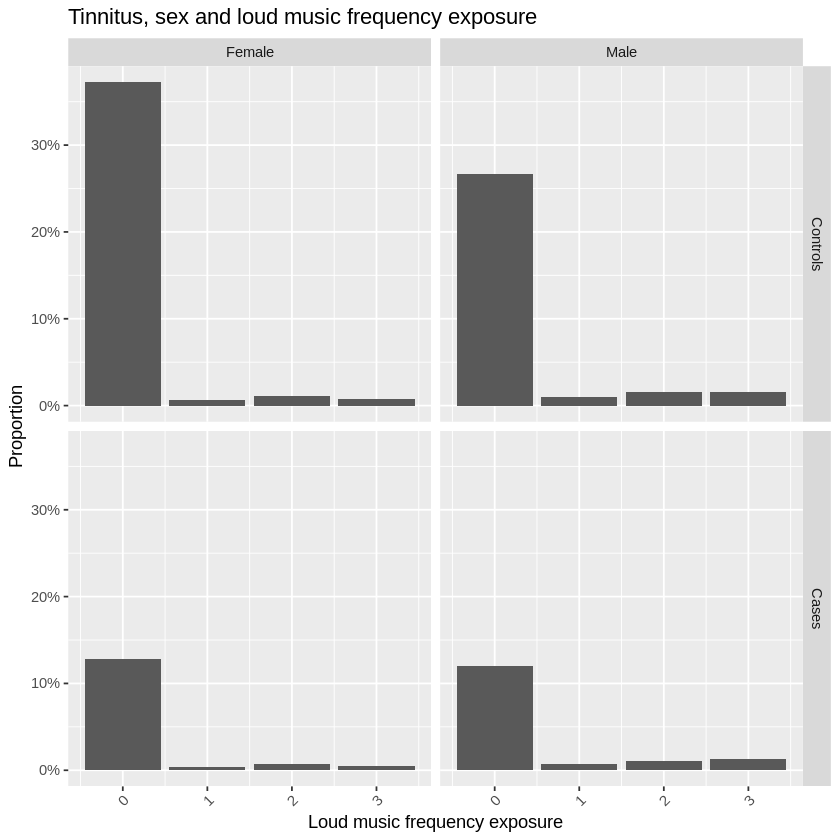

In [78]:
sex.tin.music <- ggplot(tinnitus_complete, aes(x = loud_music)) +
  geom_bar(aes(y = (..count..)/sum(..count..))) +
    labs(title = "Tinnitus, sex and loud music frequency exposure",
       x = "Loud music frequency exposure", 
       y = "Proportion of individuals") +
  scale_y_continuous(labels = scales::percent, name = "Proportion") +
  facet_grid(tinnitus ~ sex, labeller=labeller(sex = label_sex, tinnitus = label_tin)) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
sex.tin.music

In [79]:
tinnitus_complete %>%
select(age, noise_wp) %>%
group_by(noise_wp) %>%
  summarise(
    count = n(),
    mean = mean(age, na.rm = TRUE),
    sd = sd(age, na.rm = TRUE))

noise_wp,count,mean,sd
<dbl>,<int>,<dbl>,<dbl>
0,106624,59.19482,8.475410
1,6945,57.94716,8.490945
2,7497,58.61051,8.578477
3,16380,60.26667,8.094764


In [ ]:
noise.boxp <- ggboxplot(tinnitus_complete, x = "noise_wp", y = "age", 
          color = "noise_wp",
          order = c("0", "1", "2", "3"),
          ylab = "Age", xlab = "noisy workplace")
noise.boxp

In [ ]:
res1.aov <- aov(age ~ noise_wp, data = tinnitus_complete)
summary(res1.aov)
TukeyHSD(res1.aov)

In [ ]:
music.boxp <- ggboxplot(tinnitus_complete, x = "loud_music", y = "age", 
          color = "loud_music",
          order = c("0", "1", "2", "3"),
          ylab = "Age", xlab = "Loud music frequency")
music.boxp

In [ ]:
res2.aov <- aov(age ~ loud_music, data = tinnitus_complete)
summary(res2.aov)
TukeyHSD(res2.aov)

Correlation between the two noise variables for cases and controls separately using Kendall correlation

In [ ]:
cases <- tinnitus_complete %>%
  filter(tinnitus=="1")
noise_wp <- as.numeric(factor(cases$noise_wp,levels=c("0", "1", "2", "3"))) 
loud_music <- as.numeric(factor(cases$loud_music, levels=c("0", "1", "2", "3"))) 
m <- cbind(noise_wp, loud_music)
cor(m, method="kendall", use="pairwise")
cor.test(noise_wp, loud_music, method="kendall")

In [ ]:
controls <- tinnitus_complete %>%
  filter(tinnitus=="0")
noise_wp.ctr <- as.numeric(factor(controls$noise_wp,levels=c("0", "1", "2", "3"))) 
loud_music.ctr <- as.numeric(factor(controls$loud_music, levels=c("0", "1", "2", "3"))) 
m1 <- cbind(noise_wp.ctr, loud_music.ctr)
cor(m1, method="kendall", use="pairwise")
cor.test(noise_wp.ctr, loud_music.ctr, method="kendall")

Heat map for variable correlation

In [ ]:
#Heat map
noisevar.df <- as.data.frame(table(tinnitus_complete$noise_wp, tinnitus_complete$loud_music))
ggplot(noisevar.df, aes(Var1, Var2)) +
  geom_tile(aes(fill = Freq), colour = "black") +
  scale_fill_gradient(low = "white", high = "steelblue")

Fluctuation plot

In [ ]:
# Fluctuation plot
theme_nogrid <- function (base_size = 12, base_family = "") {
  theme_bw(base_size = base_size, base_family = base_family) %+replace% 
    theme(panel.grid = element_blank())   
}
ggplot(noisevar.df, aes(Var1, Var2)) +
  geom_point(aes(size = Freq, color = Freq, stat = "identity", position = "identity"), shape = 15) +
  scale_size_continuous(range = c(3,15)) + 
  scale_color_gradient(low = "white", high = "black") +
  theme_nogrid()

## 2. SRT phenotype (quantitative)

The phenotypes to be used are as follow:
1. Left ear f.20019
2. Right ear f.20021
3. Best ear (create a new variable extracting the min SRT value among f.20019 and f.20021)
4. Worst ear (create a new variable extracting the max SRT value among f.20019 and f.20021)

Age is calculated as follow:

- For people with repeated measures take age at last visit and measurement at last visit
- For people with only one measure take age at that visit

Sex corresponds to f.22001 (genetic sex):

- Male = 0
- Female = 1

Noise variable and loud music exposure frequency: same as for Tinnitus
                
1. Remove inconsistent individuals 
    - said 1,2 or 3 and in following visits said 0
    - said a higher exposure (e.g 3) and then a lower one (e.g 1 or 2) in following visits
2. Retain consistent individuals and use highest reported exposure

### a. Filter SRT codes

In [2]:
srt_all = df.final.imp %>% 
  select(IID, f.4803.0.0.rc, f.4803.1.0.rc, f.4803.2.0.rc, f.4803.3.0.rc, 
         f.21003.0.0,f.21003.1.0,f.21003.2.0,f.21003.3.0, 
         f.20019.0.0, f.20019.1.0, f.20019.2.0, f.20019.3.0,
         f.20021.0.0,f.20021.1.0,f.20021.2.0,f.20021.3.0)

head(srt_all)

ERROR: Error in df.final.imp %>% select(IID, f.4803.0.0.rc, f.4803.1.0.rc, f.4803.2.0.rc, : could not find function "%>%"


### b. Get the SRT score left ear

In [ ]:
# find out the last srt score for left ear 
# Get the # of column where first replied Yes or No:
srt_all$visit_idx = apply(srt_all, 1, function(x) unlist(which(x == 'Yes'| x == "No")))
head(srt_all)

In [ ]:
# Define offset:
# offset: refers to the # of columns between the first srt score column (i.e.f.20019.0.0) and the first recode column (i.e.f.4803.0.0_recode)
offset = which(colnames(srt_all) == 'f.20019.0.0') - which(colnames(srt_all) == 'f.4803.0.0.rc')

# Define the function to extract the last time they said yes/no
get_srt_left <- function(x) {
  visit_index=x[which(colnames(srt_all)=="visit_idx")]
  index=max(unlist(visit_index))+offset
  srt_score=x[index]
  final_score=unlist(srt_score)
  if(is.null(final_score))
  {final_score<-NA}
  return(final_score)
}

# Get the final srt score for left ear
srt_all$srt_score_left = apply(srt_all, 1, get_srt_left)
head(srt_all)

### c. Get the SRT score right ear

In [ ]:
#find out the last srt score for right ear 

srt_all$visit_idx2 = apply(srt_all, 1, function(x) unlist(which(x == 'Yes'| x == "No")))

# Define offset:
# offset: refers to the # of columns between the first srt score column (i.e.f.20021.0.0) and the first recode column (i.e.f.4803.0.0_recode.y)
offset = which(colnames(srt_all) == 'f.20021.0.0') - which(colnames(srt_all) == 'f.4803.0.0_recode.y')

# Define the function to extract the last time they said yes/no 
get_srt_right <- function(x) {
  visit_index2=x[which(colnames(srt_all)=="visit_idx2")]
  index=max(unlist(visit_index2))+offset
  srt_score=x[index]
  final_score=unlist(srt_score)
  if(is.null(final_score))
  {final_score<-NA}
  return(final_score)
}

# Get the final srt score for right ear
srt_all$srt_score_right = apply(srt_all, 1, get_srt_right)

res<-head(srt_all)

### d. Find out the age of the individuals

In [ ]:
# find out the last age for each of patient

srt_all$visit_idx3 = apply(srt_all, 1, function(x) unlist(which(x == 'Yes'| x == "No")))

# Define offset:
# offset: refers to the # of columns between the first age column (i.e.f.21003.0.0.y) and the first recode column (i.e.f.4803.0.0_recode.y)
offset = which(colnames(srt_all) == 'f.21003.0.0.y') - which(colnames(srt_all) == 'f.4803.0.0_recode.y')

# Define the function to extract the last time they said yes/no
get_srt_age <- function(x) {
  visit_index3=x[which(colnames(srt_all)=="visit_idx3")]
  index=max(unlist(visit_index3))+offset
  srt_age=x[index]
  final_age=unlist(srt_age)
  if(is.null(final_age))
  {final_age<-NA}
  return(final_age)
}

# Get the final srt age
srt_all$srt_age = apply(srt_all, 1, get_srt_age)

res<-head(srt_all)

#drop the unnecessary (temporary) variable
srt_clean <- srt_all %>% 
select(-visit_idx,-visit_idx2, -visit_idx3)

#NA for both ear (216526 individuals)
srt_NA <- srt_clean %>% 
  filter(is.na(srt_score_left) & is.na(srt_score_right))

#136222 for left ear
left_ear <- srt_clean %>% 
  filter(!is.na(srt_score_left))

#136205 for right ear
right_ear <- srt_clean %>% 
  filter(!is.na(srt_score_right))

### e. Descriptive statistics

In [ ]:
#create a categorical variable to classify the score for left and right ear
#137821 individuals have either right or left score, or both (216526 individuals who have neither the right nor left score are deleted)
#134058 have either right or left score, or both  (deleting the outliers)
srt_cat <- srt_clean %>%
  filter(!is.na(srt_score_left) | !is.na(srt_score_right)) %>% 
  mutate(srt_left_cat = case_when(
        srt_score_left < -5.5   ~  "normal",
        -5.5 <= srt_score_left & srt_score_left <= -3.5   ~  "insufficient",
          srt_score_left > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_right_cat = case_when(
        srt_score_right < -5.5   ~  "normal",
        -5.5 <= srt_score_right & srt_score_right <= -3.5   ~  "insufficient",
          srt_score_right > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  #remove the score 8 (outlier) for both ears
  filter(!(srt_score_left == 8) & !(srt_score_right == 8))

#to use the function max/min, replace all NA to 0 for numerical variables 
srt_fill_na <- srt_cat
srt_fill_na[is.na(clean <- srt_cat)] <- 0
 

# Create two new variables to show the best ear and the worst ear
srt_best_worst <-  srt_fill_na %>% 
  mutate(best = apply(select(., starts_with("f.200")), 1, function(x) min(x[x!=0])),
         worst = apply(select(., starts_with("f.200")), 1, function(x) max(x[x!=0]))
  ) %>% 
  #replace the Inf and -Inf values with 0
  mutate(best = if_else(best == Inf, 0, best),
         worst = if_else(worst == -Inf, 0, worst)
  )


#replace 0 with NA
library(dplyr) 
srt_best_worst <- na_if(srt_best_worst, 0)


#summary statistics 
summary(srt_best_worst$srt_score_left)

In [ ]:
summary(srt_best_worst$srt_score_right)

In [ ]:
summary_left <- srt_best_worst %>%
  filter(!is.na(srt_score_left)) %>% 
  summarise(std_left =sd(srt_score_left),
          mean_left = mean(srt_score_left),
          median_left = median(srt_score_left),
          n = n()
          ) 

summary_left 

In [ ]:
summary_right <- srt_best_worst %>%
  filter(!is.na(srt_score_right)) %>% 
  summarise(std_right =sd(srt_score_right),
          mean_right = mean(srt_score_right),
          median_right = median(srt_score_right),
          n = n()
          ) 

summary_right

### Plots

In [ ]:
#histogram for SRT Score for Left Ear
left_plot = srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(x = srt_score_left,color = srt_left_cat)) +
      geom_histogram(binwidth = 0.1) +
   labs(
    title = "SRT Score for Left Ear (by category)",
    x = "SRT Score for Left ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 


left_plot

In [ ]:
#QQ plot for SRT Score for Left Ear
qq_left_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left))) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_total

In [ ]:
qq_left_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_left)) %>% 
  ggplot(aes(sample = (srt_score_left - mean(srt_score_left))/sd(srt_score_left), color = srt_left_cat)) +
  stat_qq() +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Left)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_left_by_cat

In [ ]:
#histogram for SRT Score for Right Ear 
right_plot <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(x = srt_score_right, color=srt_right_cat) ) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for Right Ear (by category)",
    x = "SRT Score for Right ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 
right_plot

In [ ]:
#QQ plot for SRT Score for Right Ear
qq_right_total <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_total

In [ ]:
qq_right_by_cat <- srt_best_worst %>% 
  filter(!is.na(srt_score_right)) %>% 
  ggplot(aes(sample = (srt_score_right - mean(srt_score_right))/sd(srt_score_right), color = srt_right_cat)) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line() +
  labs(title="QQ plot for SRT Score (Right)",
       y = "SRT Score Quantile",
       x = "Normal Quantile") +
theme_classic()

qq_right_by_cat

In [ ]:
srt_best_worst_cat <- srt_best_worst %>%
  mutate(srt_best_cat = case_when(
        best < -5.5   ~  "normal",
        -5.5 <= best & best <= -3.5   ~  "insufficient",
          best > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  mutate(srt_worst_cat = case_when(
        worst < -5.5   ~  "normal",
        -5.5 <= worst & worst <= -3.5   ~  "insufficient",
          worst > -3.5  ~ "poor",
         TRUE                    ~ ""
  )) %>% 
  filter(!is.na(best) | !is.na(worst))



best_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = best, color=srt_best_cat) ) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for the Best Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 
best_plot

In [ ]:
qq_best <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (best - mean(best))/sd(best))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Best SRT Score",
       y = "SRT Score Quantiles",
       x = "normal Quantiles") + 
theme_classic()  

qq_best

In [ ]:
worst_plot <- srt_best_worst_cat %>% 
  ggplot(aes(x = worst, color=srt_worst_cat)) +
      geom_histogram(binwidth = 0.1) +
  labs(
    title = "SRT Score for the Worst Ear (by category)",
    x = "SRT Score for the Best ",
    y = "Count"
    ) + 
   scale_x_continuous(
    breaks = c(-10, -5.5, -3.5, 0, 3.5, 5.5),
    labels = c("-10", "-5.5", "-3.5", "0", "3.5", "5.5")) +
  scale_y_continuous(
    breaks = c(2500, 5000, 7500, 10000, 12500, 15000),
    labels = c("2500", "5000", "7500", "10000", "12500", "15000")) +
  scale_color_discrete("SRT Score Category",labels=c("normal","insuficient","poor")) 
 

worst_plot

In [ ]:
qq_worst <- srt_best_worst_cat %>% 
  ggplot(aes(sample = (worst - mean(worst))/sd(worst))) +
  stat_qq(distribution = stats::qnorm) +
  stat_qq_line(col= 'blue') +
  labs(title="QQ plot for the Worst SRT Score",
       y = "SRT Score Quantiles",
       x = "normal quantiles") +
theme_classic()  

qq_worst